https://sciencecareer.data.blog/2020/05/04/auto-colorization-of-black-and-white-images-using-machine-learning-auto-encoders-technique/

In [1]:
import os
import glob
import cv2
import time
import random
import webbrowser
import numpy as np
import pandas as pd
from numpy import reshape
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

from cv2 import imread, imwrite
import tensorflow as tf
#from tensorflow.keras import datasets, layers, models
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization, Input, RepeatVector, concatenate
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from skimage import color
from skimage.io import imsave
from skimage.transform import resize
from skimage.io import imsave, imread, imshow
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

#from __future__ import absolute_import
#from __future__ import division
#rom __future__ import print_function       #repasar funcion y explicar en exposicion

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [2]:
# Get images
img = []
for filename in os.listdir('quality/'):
    img.append(img_to_array(load_img('quality/'+filename)))

In [3]:
len(img)

14

In [4]:
X = []
Y = []

for x in img:
    lab = rgb2lab(x)
    X.append(lab[:,:,0])
    Y.append(lab[:,:,1:] / 128)

In [5]:
X = np.asarray(X, dtype=float)/255.0
Y = np.asarray(Y, dtype=float)/255.0

In [6]:
#Encoder
encoder_input = Input(shape=(1024, 1024, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=encoder_input, outputs=decoder_output)

In [8]:
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])


Epoch 1/100
1/1 [==============================] - 52s 52s/step - loss: 0.0067 - accuracy: 0.4662 - val_loss: 0.8470 - val_accuracy: 0.7222
Epoch 2/100
1/1 [==============================] - 52s 52s/step - loss: 0.8949 - accuracy: 0.5290 - val_loss: 0.0036 - val_accuracy: 0.3427
Epoch 3/100
1/1 [==============================] - 48s 48s/step - loss: 0.0044 - accuracy: 0.4724 - val_loss: 0.0040 - val_accuracy: 0.2985
Epoch 4/100
1/1 [==============================] - 49s 49s/step - loss: 0.0040 - accuracy: 0.4725 - val_loss: 0.0041 - val_accuracy: 0.2733
Epoch 5/100
1/1 [==============================] - 45s 45s/step - loss: 0.0040 - accuracy: 0.4673 - val_loss: 0.0044 - val_accuracy: 0.2716
Epoch 6/100
1/1 [==============================] - 48s 48s/step - loss: 0.0041 - accuracy: 0.4669 - val_loss: 0.0041 - val_accuracy: 0.3108
Epoch 7/100
1/1 [==============================] - 49s 49s/step - loss: 0.0041 - accuracy: 0.4966 - val_loss: 0.0041 - val_accuracy: 0.6056
Epoch 8/100
1/1 [===

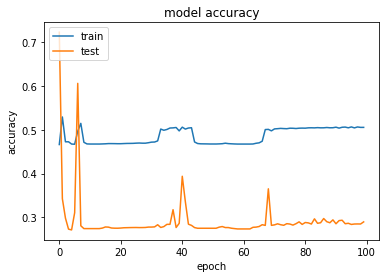

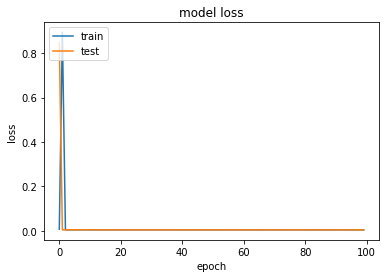

In [9]:
history = model.fit(X,Y,validation_split=0.1, epochs=100, verbose = 1)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [2]:
color_me = []
for filename in os.listdir('test256/'):
        color_me.append(img_to_array(load_img('test256/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [4]:
json_file = open('model_collab2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_collab2.h5")

In [5]:
output = model.predict(color_me)
output = output * 128

In [11]:
len(output)

64

In [12]:
# Output colorizations
for i in range(len(output)):
    result = np.zeros((256, 256, 3))
    result[:,:,0] = color_me[i][:,:,0]
    result[:,:,1:] = output[i]
    imsave("result3/uint8_"+str(i)+".png", lab2rgb(result))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [13]:
model_json = model.to_json()
with open('model2.json', 'w') as json_file:
    json_file.write(model_json)

model.save('model2.h5')

in_hsv_h = color.convert_colorspace(output, 'RGB', 'HSV')
in_hsv_s = in_hsv_h.copy()
in_hsv_v = in_hsv_h.copy()

for i in range(newImage.shape[0]):
    in_hsv_h[i,:,0] = np.sort(in_hsv_h[i,:,0])
    in_hsv_s[i,:,1] = np.sort(in_hsv_s[i,:,1])
    in_hsv_v[i,:,2] = np.sort(in_hsv_v[i,:,2])

imsave('testing-sorted-hue.png', (color.convert_colorspace(in_hsv_h, 'HSV', 'RGB')*255).astype(np.uint8))
imsave('testing-sorted-saturation.png', (color.convert_colorspace(in_hsv_s, 'HSV', 'RGB')*255).astype(np.uint8))